In [1]:
import numpy as np
import open3d as o3d

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


In [1]:
# Function to display the point cloud

import plotly.graph_objects as go

def visualize_point_cloud(pc):
  o3d.visualization.draw_geometries([pc],
                                  zoom=0.3412,
                                  front=[0.4257, -0.2125, -0.8795],
                                  lookat=[2.6172, 2.0475, 1.532],
                                  up=[-0.0694, -0.9768, 0.2024])

In [2]:
# Function to display registration results
def draw_registration_result(source, target, transformation):
    source_temp = copy.deepcopy(source)
    target_temp = copy.deepcopy(target)
    source_temp.paint_uniform_color([1, 0.706, 0])
    target_temp.paint_uniform_color([0, 0.651, 0.929])
    source_temp.transform(transformation)
    source_temp_downsampled = source_temp.voxel_down_sample(voxel_size=0.01) # downsampling to avoid running out of memory in Colab
    target_temp_downsampled = target_temp.voxel_down_sample(voxel_size=0.01) # downsampling to avoid running out of memory in Colab
    pcd = source_temp_downsampled + target_temp_downsampled
    visualize_point_cloud(pcd)

In [3]:
def visualize_reference_frame(fig, tmatrix):

  R = tmatrix[0:3,0:3]
  tx = tmatrix[0,3]
  ty = tmatrix[1,3]
  tz = tmatrix[2,3]
  axes_size = 0.05

  x = np.asarray([tx, tx+axes_size*(R[0,0]), tx+axes_size*(R[0,1]), tx+axes_size*(R[0,2])])
  y = np.asarray([ty, ty+axes_size*(R[1,0]), ty+axes_size*(R[1,1]), ty+axes_size*(R[1,2])])
  z = np.asarray([tz, tz+axes_size*(R[2,0]), tz+axes_size*(R[2,1]), tz+axes_size*(R[2,2])])

  pairs = [(0,1), (0,2), (0,3)]

  x_lines = list()
  y_lines = list()
  z_lines = list()

  for p in pairs:
    for i in range(2):
      x_lines.append(x[p[i]])
      y_lines.append(y[p[i]])
      z_lines.append(z[p[i]])
    x_lines.append(None)
    y_lines.append(None)
    z_lines.append(None)

  ## set the mode to lines to plot only the lines and not the balls/markers
  trace2 = go.Scatter3d(
      x=x_lines[0:2],
      y=y_lines[0:2],
      z=z_lines[0:2],
      mode='lines',
      line = dict(width = 4, color = 'rgb(255, 0, 0)')
  )

  trace3 = go.Scatter3d(
      x=x_lines[3:5],
      y=y_lines[3:5],
      z=z_lines[3:5],
      mode='lines',
      line = dict(width = 4, color = 'rgb(0, 255, 0)')
  )

  trace4 = go.Scatter3d(
      x=x_lines[6:8],
      y=y_lines[6:8],
      z=z_lines[6:8],
      mode='lines',
      line = dict(width = 4, color = 'rgb(0, 0, 255)')
  )

  #fig = go.Figure(data=[trace2, trace3, trace4])
  fig.add_trace(trace2)
  fig.add_trace(trace3)
  fig.add_trace(trace4)

  arrow_tip_ratio = 0.3
  arrow_starting_ratio = 0.98

  ## the cone will point in the direction of vector field u, v, w
  ## so we take this to be the difference between each pair

  colors = ['rgb(255,0,0)', 'rgb(0,255,0)', 'rgb(0,0,255)']
  for p in pairs:
      fig.add_trace(go.Cone(
          x=[x[p[0]] + arrow_starting_ratio*(x[p[1]] - x[p[0]])],
          y=[y[p[0]] + arrow_starting_ratio*(y[p[1]] - y[p[0]])],
          z=[z[p[0]] + arrow_starting_ratio*(z[p[1]] - z[p[0]])],
          u=[arrow_tip_ratio*(x[p[1]] - x[p[0]])],
          v=[arrow_tip_ratio*(y[p[1]] - y[p[0]])],
          w=[arrow_tip_ratio*(z[p[1]] - z[p[0]])],
          showscale=False,
          colorscale=[[0, colors[p[1]-1]], [1, colors[p[1]-1]]]
          ))
  fig.update_layout(showlegend=False)

In [4]:
# Read a point cloud from a file and visualize it

# fragment.ply can be downloaded from Moodle or from https://github.com/HuangCongQing/Point-Clouds-Visualization/blob/master/2open3D/data/fragment.ply
cloud = o3d.io.read_point_cloud('./data/fragment.ply')
dcloud = cloud.voxel_down_sample(voxel_size=0.1) # downsampling to avoid running out of memory in Colab
visualize_point_cloud(cloud)

NameError: name 'o3d' is not defined

In [25]:
# Functions to read files containing the ground truth camera poses

class CameraPose:
    def __init__(self, meta, mat):
        self.metadata = meta
        self.pose = mat
    def __str__(self):
        return 'Metadata : ' + ' '.join(map(str, self.metadata)) + '\n' + \
            "Pose : " + "\n" + np.array_str(self.pose)

def read_trajectory(filename):
    traj = []
    with open(filename, 'r') as f:
        metastr = f.readline();
        while metastr:
            metadata = map(int, metastr.split())
            mat = np.zeros(shape = (4, 4))
            for i in range(4):
                matstr = f.readline();
                mat[i, :] = np.fromstring(matstr, dtype = float, sep=' \t')
            traj.append(CameraPose(metadata, mat))
            metastr = f.readline()
    return traj

In [26]:
# Example reading poses from file
gtposes = read_trajectory('./data/livingroom1-traj.txt')
print(gtposes[33].pose)

[[-2.33837209e-02  2.90851924e-01 -9.56482284e-01 -3.54641684e-01]
 [-8.29616136e-19 -9.56743893e-01 -2.90931475e-01  1.11051869e+00]
 [-9.99726563e-01 -6.80306042e-03  2.23722322e-02  2.25918695e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00]]


In [27]:
# Example converting a rotation matrix to Euler angles
from scipy.spatial.transform import Rotation as R
r = R.from_matrix(np.matmul(np.linalg.inv(gtposes[33].pose[:3,:3]),gtposes[34].pose[:3,:3]))
print(r.as_euler('zxy', degrees=True))

[ 0.28403948 -0.02065491  0.93402579]


['00000.jpg', '00001.jpg', '00002.jpg', '00003.jpg', '00004.jpg', '00005.jpg', '00006.jpg', '00007.jpg', '00008.jpg', '00009.jpg', '00010.jpg', '00011.jpg', '00012.jpg', '00013.jpg', '00014.jpg', '00015.jpg', '00016.jpg', '00017.jpg', '00018.jpg', '00019.jpg', '00020.jpg', '00021.jpg', '00022.jpg', '00023.jpg', '00024.jpg', '00025.jpg', '00026.jpg', '00027.jpg', '00028.jpg', '00029.jpg', '00030.jpg', '00031.jpg', '00032.jpg', '00033.jpg', '00034.jpg', '00035.jpg', '00036.jpg', '00037.jpg', '00038.jpg', '00039.jpg', '00040.jpg', '00041.jpg', '00042.jpg', '00043.jpg', '00044.jpg', '00045.jpg', '00046.jpg', '00047.jpg', '00048.jpg', '00049.jpg', '00050.jpg', '00051.jpg', '00052.jpg', '00053.jpg', '00054.jpg', '00055.jpg', '00056.jpg', '00057.jpg', '00058.jpg', '00059.jpg', '00060.jpg', '00061.jpg', '00062.jpg', '00063.jpg', '00064.jpg', '00065.jpg', '00066.jpg', '00067.jpg', '00068.jpg', '00069.jpg', '00070.jpg', '00071.jpg', '00072.jpg', '00073.jpg', '00074.jpg', '00075.jpg', '00076.jpg'

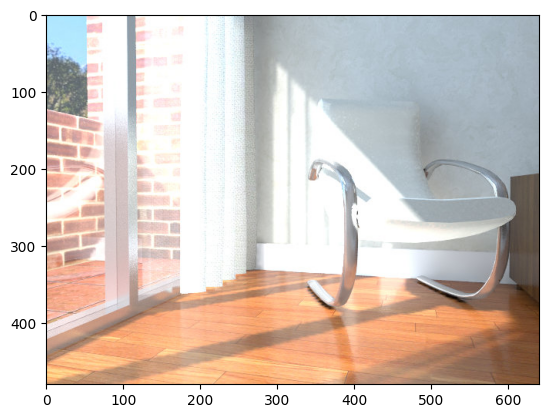

00001.jpg
Image of size 640x480, with 3 channels.
Use numpy.asarray to access buffer data.


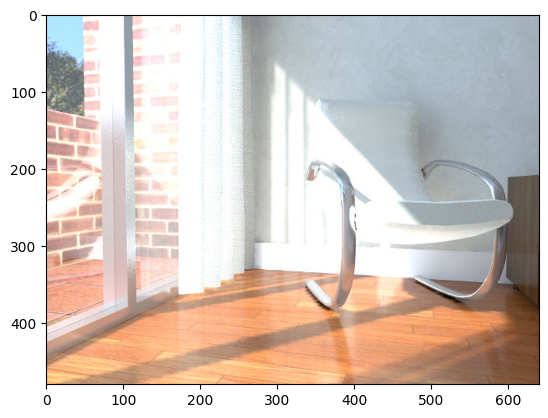

00002.jpg
Image of size 640x480, with 3 channels.
Use numpy.asarray to access buffer data.


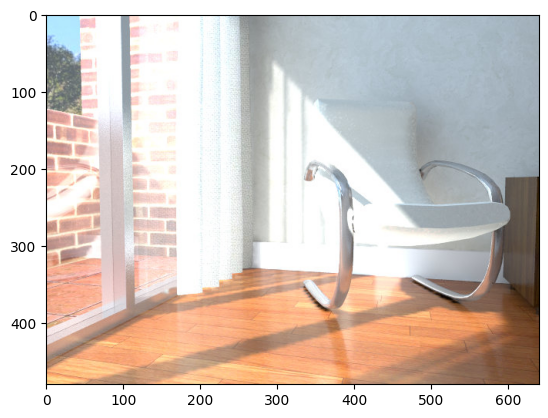

00003.jpg
Image of size 640x480, with 3 channels.
Use numpy.asarray to access buffer data.


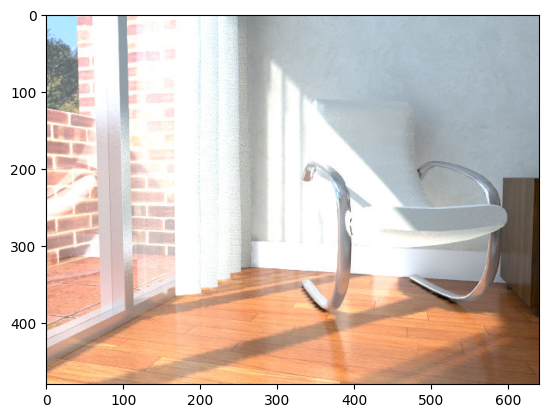

00004.jpg
Image of size 640x480, with 3 channels.
Use numpy.asarray to access buffer data.


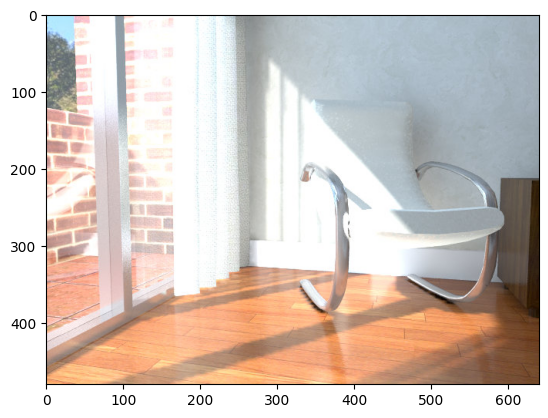

00005.jpg
Image of size 640x480, with 3 channels.
Use numpy.asarray to access buffer data.


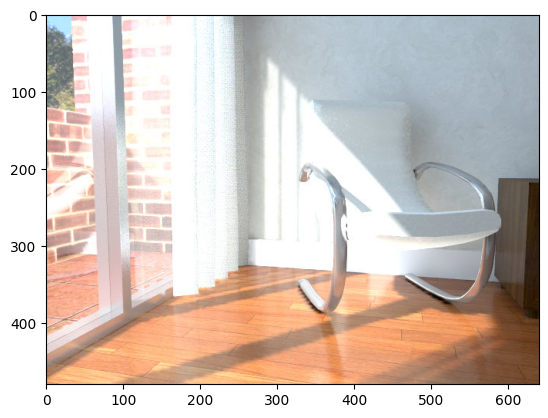

00006.jpg
Image of size 640x480, with 3 channels.
Use numpy.asarray to access buffer data.


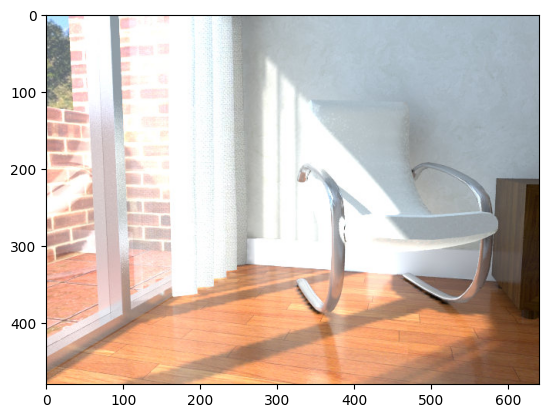

00007.jpg
Image of size 640x480, with 3 channels.
Use numpy.asarray to access buffer data.


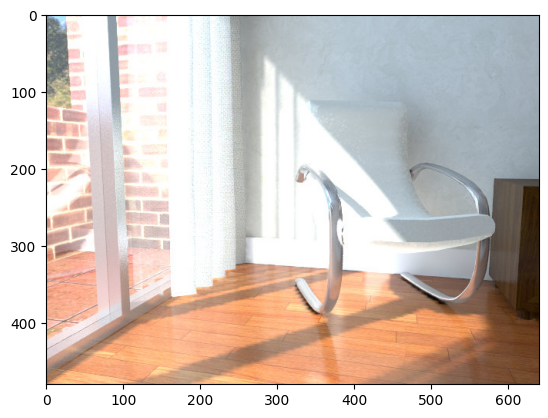

00008.jpg
Image of size 640x480, with 3 channels.
Use numpy.asarray to access buffer data.


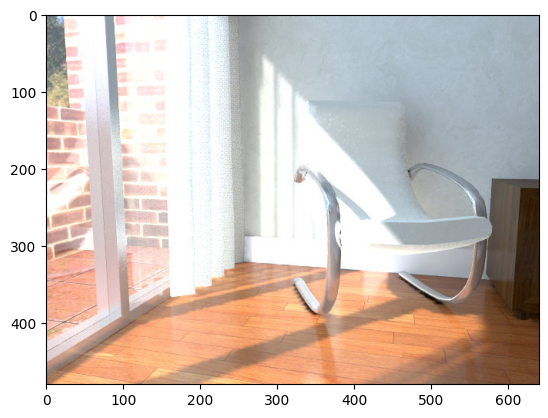

00009.jpg
Image of size 640x480, with 3 channels.
Use numpy.asarray to access buffer data.


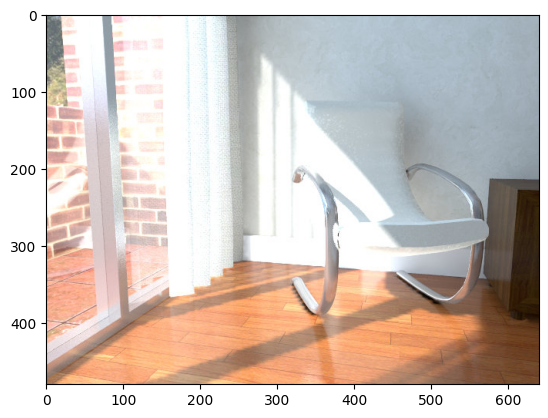

In [28]:
# Example for reading the image files in a folder
import os
import matplotlib.pyplot as plt

my_path = './data/livingroom1-color/'
rgdfiles = sorted(os.listdir(my_path))
print(rgdfiles)
for i in range(10): #range(len(rgdfiles)):
  print(rgdfiles[i])
  color_raw = o3d.io.read_image('./data/livingroom1-color/%(number)05d.jpg'%{"number": i})
  print(color_raw)
  plt.imshow(color_raw)
  plt.show()